This example is created as part of Grace Hopper Conference 2020, Open Sorce Day Workshop

# Setup

In [224]:
!pip install metriks
!pip install catboost

In [225]:
from catboost import CatBoost
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import metriks
from sklearn.utils.extmath import softmax
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn

# Download a Benchmarck Dataset

For this example we will use a shrunk version of [Microsofts Learning to Rank Dataset](https://www.microsoft.com/en-us/research/project/mslr/), availabe in [Catboost library datasets](https://catboost.ai/docs/concepts/python-reference_datasets.html)

In [226]:
from catboost.datasets import msrank_10k

# Understanding Our Dataset

Each row in the dataset is a query-url pair along with relevance label. Relevance labels are from 0 (irrelevant) to 4 (perfectly relevant).

"The first column is relevance label of the pair, the second column is query id, and the following columns are features. The larger value the relevance label has, the more relevant the query-url pair is." (from Microsoft's website)

In [227]:
train_df, test_df = msrank_10k()

#train_df.sort_values([1])
#test_df.sort_values([1])

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

In [228]:
print("Train set size: " + str(X_train.shape[0]))
print("Test set size: " + str(X_test.shape[0]))
print("Number of features: " + str(X_train.shape[1]))
print("Number of unique train queries: " + str(np.unique(queries_train).shape[0]))
print("Number of unique test queries: " + str(np.unique(queries_test).shape[0]))

Train set size: 10000
Test set size: 10000
Number of features: 136
Number of unique train queries: 87
Number of unique test queries: 88


Distribution of labels in train set

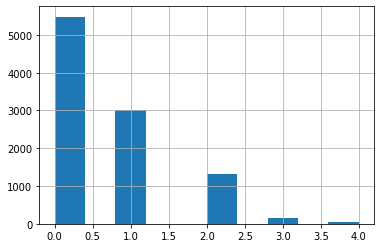

In [229]:
pd.Series(y_train).hist()

Distribution of labels in test set

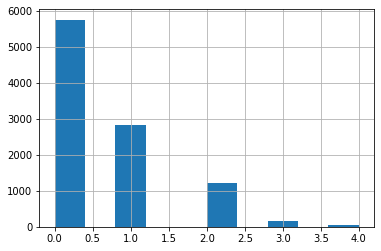

In [230]:
pd.Series(y_test).hist()

# Building Ranking Models

We will build two ranking models using LightGBM and XGBoost libraries, and train them with training data

In [231]:
count_of_urls_per_query = pd.Series(queries_train).value_counts().sort_index()

In [232]:
lgb_ranker = lgb.LGBMRanker()
lgb_ranker.fit(X_train, y_train, group=count_of_urls_per_query)

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [233]:
xgb_ranker = xgb.XGBRanker()
xgb_ranker.fit(X_train, y_train, group=count_of_urls_per_query)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
          max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
          n_estimators=100, n_jobs=-1, nthread=None, objective='rank:pairwise',
          random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=None, subsample=1, verbosity=1)

# Evaluating the Models

In [234]:
lgb_predictions = lgb_ranker.predict(X_test)
xgb_predictions = xgb_ranker.predict(X_test)

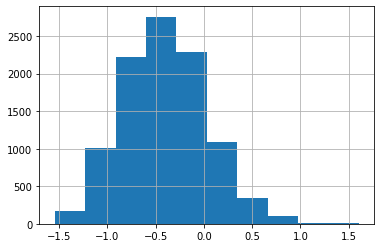

In [235]:
pd.Series(lgb_predictions).hist()

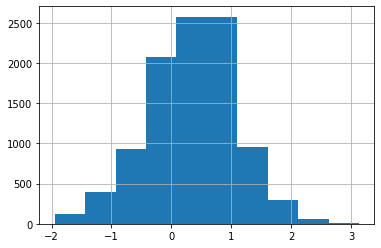

In [236]:
pd.Series(xgb_predictions).hist()

We need the predicted probabilites to be in range [0,1], so we scale them to the desired range

In [237]:
'''scaler = MinMaxScaler()
lgb_predictions = scaler.fit_transform(np.array([lgb_predictions]).reshape(-1, 1)).reshape(1, -1)
xgb_predictions = scaler.fit_transform(np.array([xgb_predictions]).reshape(-1, 1)).reshape(1, -1)'''
lgb_predictions = softmax(np.array([lgb_predictions]))
xgb_predictions = softmax(np.array([xgb_predictions]))

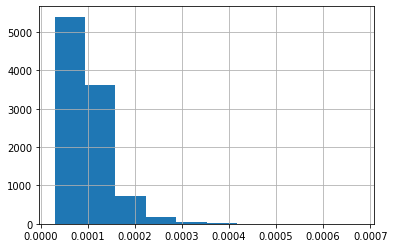

In [238]:
pd.Series(lgb_predictions[0]).hist()

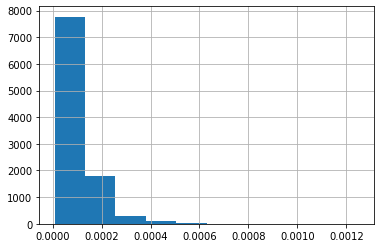

In [239]:
pd.Series(xgb_predictions[0]).hist()

In [240]:
max_relevance = np.max(y_train)
y_test /= max_relevance #ndcg function requires values in [0,1] range

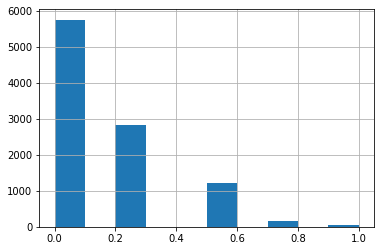

In [241]:
pd.Series(y_test).hist()

In [242]:
metriks.ndcg(np.array([y_test]), lgb_predictions)

0.8945146804214607

In [243]:
metriks.ndcg(np.array([y_test]), xgb_predictions)

0.8909599361726613

**Based on NDCG evalution, the performance difference between the two models are almost negligible, and both have satisfactory performance for this sample dataset.**

In [248]:
#y_test[y_test==1]= 0.1
#y_test[y_test==0] =1
y_test[y_test<1] = 0

In [249]:
def plot_confusion_matrix_at_k(true_labels,predictions,k,title='Confusion Matrix'):
  tn, fp, fn, tp = metriks.confusion_matrix_at_k(np.array([y_test]), lgb_predictions,k=1)
  n_samples = tn.shape[0]
  df = pd.DataFrame([[np.sum(tn)/n_samples,np.sum(fp)/n_samples],[np.sum(fn)/n_samples,np.sum(tp)/n_samples]])
  ax = sn.heatmap(df,annot=True)
  ax.set(xlabel='Predicted Label', ylabel='True Label',title=title)

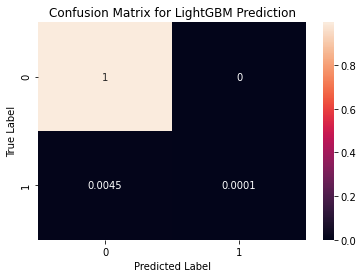

In [250]:
plot_confusion_matrix_at_k(np.array([y_test]),lgb_predictions,1,title='Confusion Matrix for LightGBM Prediction')

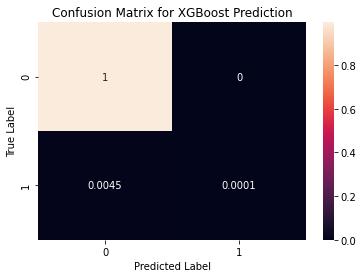

In [251]:
plot_confusion_matrix_at_k(np.array([y_test]),xgb_predictions,1,title='Confusion Matrix for XGBoost Prediction')